In [1]:
from imports import *

In [2]:
image_total = np.load("/data/vidales/images/image_v1303_10ophits_c1_inv.npy")

In [64]:
image_onlype = np.load("/data/vidales/images/image_v1303_onlype.npy")

In [3]:
table = pq.read_table('saved_archives/v1303_noTPCselection_c1&c2.parquet')
nuvT = ak.from_iter(table.column('nuvT').to_pylist())
nuvT_c = ak.from_iter(table.column('nuvT_c').to_pylist())
nuvT_c_bunch = ak.from_iter(table.column('nuvT_c_bunch').to_pylist())
dEpromx = ak.from_iter(table.column('dEpromx').to_pylist())
dEpromy = ak.from_iter(table.column('dEpromy').to_pylist())
dEpromz = ak.from_iter(table.column('dEpromz').to_pylist())
del table

In [4]:
dEpromx = np.array(dEpromx).flatten()
dEpromy = np.array(dEpromy).flatten()
dEpromz = np.array(dEpromz).flatten()
nuvT = np.array(nuvT).flatten()
nuvT_c = np.array(nuvT_c).flatten()
nuvT_c_bunch = np.array(nuvT_c_bunch).flatten()
dEpromx = dEpromx.reshape(-1, 1)
dEpromy = dEpromy.reshape(-1, 1)
dEpromz = dEpromz.reshape(-1, 1)
nuvT = nuvT.reshape(-1, 1)
nuvT_c = nuvT_c.reshape(-1, 1)
nuvT_c_bunch = nuvT_c_bunch.reshape(-1, 1)

**Si TPC selection**

In [ ]:
#dEpromx = np.abs(dEpromx)

**invertir ya que también se invirtió el tiempo en la imagen**

In [5]:
nuvT_c_inv = np.max(nuvT_c)- nuvT_c + np.min(nuvT_c)

In [47]:
#y = np.column_stack((nuvT_c, dEpromx_f, dEpromy_f, dEpromz_f))
y = np.column_stack((nuvT_c, dEpromx, dEpromy, dEpromz))
y_np = ak.to_numpy(y)
print("Merged y_np:")
print(y_np)
print(np.shape(y_np))

Merged y_np:
[[1462.42688725 -141.81035117  140.83112553   74.82157564]
 [1480.24647869 -128.18496115  158.65734985  187.35995061]
 [ 643.02543649   89.7728596  -156.06595153  218.71311199]
 ...
 [ 891.94434413 -124.34233789   15.40607009  319.10272126]
 [ 514.17493045  122.74146747   88.72589418  287.34965045]
 [ 268.03104886   36.9916876    78.19434956  251.45103767]]
(21964, 4)


In [48]:
from sklearn.preprocessing import MinMaxScaler
# Define the column indices you want to scale to [0, 1] and [-1, 1]
# For 4 entries (t,x,y,z):

columns_0_to_1 = [0,3]  # For example, columns 0 and 2 to scale to [0, 1]
columns_minus1_to_1 = [1,2]  # For example, columns 1 and 3 to scale to [-1, 1]

# For 3 entries (x,y,z):

#columns_0_to_1 = [2]  # For example, columns 0 and 2 to scale to [0, 1]
#columns_minus1_to_1 = [0, 1]  # For example, columns 1 and 3 to scale to [-1, 1]

# Initialize two scalers
scaler_0_1 = MinMaxScaler(feature_range=(0, 1))
scaler_minus1_1 = MinMaxScaler(feature_range=(-1, 1))

# Apply scaling for columns that need [0, 1]
y_np_scaled_0_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_0_1[:, columns_0_to_1] = scaler_0_1.fit_transform(y_np[:, columns_0_to_1])

# Apply scaling for columns that need [-1, 1]
y_np_scaled_minus1_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_minus1_1[:, columns_minus1_to_1] = scaler_minus1_1.fit_transform(y_np[:, columns_minus1_to_1])

# Combine the results (scaled data)
y_scaled_combined = np.copy(y_np)  # Start with the original data
y_scaled_combined[:, columns_0_to_1] = y_np_scaled_0_1[:, columns_0_to_1]
y_scaled_combined[:, columns_minus1_to_1] = y_np_scaled_minus1_1[:, columns_minus1_to_1]

# Print the scaled data
print("Scaled Data (columns 0 and 3 -> scaled to [0, 1] and columns 1 and 2 -> scaled to [-1, 1]):")
print(y_scaled_combined)

Scaled Data (columns 0 and 3 -> scaled to [0, 1] and columns 1 and 2 -> scaled to [-1, 1]):
[[ 0.95919574 -0.70778976  0.69523988  0.13987098]
 [ 0.97086068 -0.63959104  0.7834291   0.36412399]
 [ 0.42280517  0.45134609 -0.77355807  0.42660082]
 ...
 [ 0.58575064 -0.62035768  0.0747418   0.62664522]
 [ 0.33845799  0.61636279  0.43746685  0.5633715 ]
 [ 0.17732909  0.18716222  0.3853656   0.49183704]]


In [49]:
test_size = int(np.floor(0.30*np.shape(y_np)[0]) )
print(test_size)

6589


In [66]:
x_train, x_test = image_total[:-test_size], image_total[-test_size:]
print('x_train dim.:',x_train.shape)
print('x_test dim.:', x_test.shape)

x_train dim.: (15375, 59, 70, 16)
x_test dim.: (6589, 59, 70, 16)


In [67]:
x_train_pe, x_test_pe = image_onlype[:-test_size], image_onlype[-test_size:]
print('x_train dim.:',x_train.shape)
print('x_test dim.:', x_test.shape)

x_train dim.: (15375, 59, 70, 16)
x_test dim.: (6589, 59, 70, 16)


In [54]:
y_train, y_test = y_scaled_combined[:-test_size], y_scaled_combined[-test_size:]

### Models

In [84]:
def create_cnn_model_relu(x_train, conv_dim):

    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.optimizers import Adam
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    model = layers.Conv2D(32, conv_dim, padding='same')(input_layer)
    model = layers.MaxPooling2D((2,2), padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(64, (3,3), padding='same')(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    
    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.3)(model) 
    
    # Output layer
    output_layer = layers.Dense(4, activation='linear')(model)
    
    # Create the model
    model_def = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def

In [52]:
def create_cnn_model(x_train, conv_dim):

    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.optimizers import Adam
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    model = layers.Conv2D(32, conv_dim, padding='same')(input_layer)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(64, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Third convolutional block
    model = layers.Conv2D(128, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Fourth convolutional block
    model = layers.Conv2D(256, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    
    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(1024, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.3)(model) 
    
    # Output layer
    output_layer = layers.Dense(4, activation='linear')(model)
    
    # Create the model
    model_def = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def

In [37]:
def create_cnn_model_new(x_train, conv_dim):
    from tensorflow.keras import layers, models

    """
    Creates a CNN model with adaptive MaxPooling based on input image size.
    
    Parameters:
    - x_train: Training data to infer input shape.
    - conv_dim: Kernel size for the first convolutional layer.
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    model = layers.Conv2D(32, conv_dim, padding='same')(input_layer)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    
    # Ajustar MaxPooling según el tamaño de la imagen
    if input_shape[0] < 10:  # Para la imagen pequeña (9,36)
        model = layers.MaxPooling2D((1,2), padding='same')(model)  
    else:  # Para la imagen grande (59,70)
        model = layers.MaxPooling2D((2,2), padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(64, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Third convolutional block
    model = layers.Conv2D(128, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)

    # Ajuste en el último MaxPooling si la imagen es muy pequeña
    if input_shape[0] < 10:  
        model = layers.MaxPooling2D((1,1), padding='same')(model)  # No reducir más
    else:
        model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Fourth convolutional block
    model = layers.Conv2D(256, (3,3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(1024, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.3)(model) 
    
    # Output layer
    output_layer = layers.Dense(3, activation='linear')(model)
    
    # Create the model
    model_def = models.Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def


**Current model 2- RESNET**

In [76]:
import tensorflow as tf
from tensorflow.keras import layers, models

def resnet50_regression(x_train):
    """
    Build a modified ResNet-50 model for a custom input size with 16 channels.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input = layers.Input(shape=input_shape)

    # Modify the first convolution layer to accept 16 input channels
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Add the residual blocks with appropriate downsampling and kernel sizes
    def conv_block(input, filters, kernel_size=3, stride=1, downsample=False):
        shortcut = input
        x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(input)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(4 * filters, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        if downsample:
            shortcut = layers.Conv2D(4 * filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(input)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        return x

    # Define stages with the adjusted downsampling
    x = conv_block(x, 64, downsample=True)
    for _ in range(2):
        x = conv_block(x, 64)

    x = conv_block(x, 128, stride=2, downsample=True)
    for _ in range(3):
        x = conv_block(x, 128)

    x = conv_block(x, 256, stride=1, downsample=True) # Typically it would be with stride 2 however our image size 57x60 not 256x256
    for _ in range(5):
        x = conv_block(x, 256)

    x = conv_block(x, 512, stride=1, downsample=True) # Typically it would be with stride 2 however our image size 57x60 not 256x256
    for _ in range(2):
        x = conv_block(x, 512)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.4)(x)  # Add Dropout before Dense layer

    # Output layer (for regression or classification)
    output = layers.Dense(3)(x)  # 4 output units for regression task (adjust as needed)

    model = models.Model(inputs=input, outputs=output)

    # Compile the model (example for regression task)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    return model

**Y-model**

In [12]:
def y_model(x_train_pe, x_train_time, conv_dim):
    from tensorflow.keras import layers, models
    from tensorflow.keras.optimizers import Adam
    
    """
    Creates a CNN model that takes two inputs (pe_image and time_image),
    processes them through separate convolutional blocks, and then merges them.
    
    Parameters:
    - x_train_pe: The input data for the photoelectron (pe) images.
    - x_train_time: The input data for the time images.
    - conv_dim: The kernel size for the convolution layers.
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layers for both images
    input_pe = layers.Input(shape=(x_train_pe.shape[1], x_train_pe.shape[2], x_train_pe.shape[3]))
    input_time = layers.Input(shape=(x_train_time.shape[1], x_train_time.shape[2], x_train_time.shape[3]))

    # First convolutional block for pe_image
    pe_model = layers.Conv2D(32, conv_dim, padding='same')(input_pe)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    # Second convolutional block for pe_image
    pe_model = layers.Conv2D(64, (3,3), padding='same')(pe_model)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    # Third convolutional block for pe_image
    pe_model = layers.Conv2D(128, (3,3), padding='same')(pe_model)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    # Fourth convolutional block for pe_image
    pe_model = layers.Conv2D(256, (3,3), padding='same')(pe_model)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    # First convolutional block for time_image
    time_model = layers.Conv2D(32, conv_dim, padding='same')(input_time)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    # Second convolutional block for time_image
    time_model = layers.Conv2D(64, (3,3), padding='same')(time_model)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    # Third convolutional block for time_image
    time_model = layers.Conv2D(128, (3,3), padding='same')(time_model)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    # Fourth convolutional block for time_image
    time_model = layers.Conv2D(256, (3,3), padding='same')(time_model)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    # Merge both models
    merged = layers.concatenate([pe_model, time_model])

    # Flatten the merged output and pass through dense layers
    merged = layers.Flatten()(merged)
    merged = layers.Dense(1024, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    merged = layers.Dense(512, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    merged = layers.Dense(256, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    merged = layers.Dense(128, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)

    # Output layer
    output_layer = layers.Dense(3, activation='linear')(merged)

    # Create the model
    model_def = models.Model(inputs=[input_pe, input_time], outputs=output_layer)

    # Compile the model
    model_def.compile(loss='mse', optimizer=Adam(), metrics=['mse'])

    return model_def

In [17]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

def zero_out_branch(layers_list):
    """Set all weights and biases of the given layers to zero."""
    for layer in layers_list:
        if len(layer.get_weights()) > 0:  # Check if the layer has weights
            weights, biases = layer.get_weights()
            layer.set_weights([np.zeros_like(weights), np.zeros_like(biases)])

def pertenece_a_rama(layer, nombre_input):
    """
    Retorna True si, siguiendo recursivamente los nodos de entrada,
    se llega a una capa InputLayer cuyo nombre contiene 'nombre_input'.
    """
    # Si la capa es un InputLayer, verificamos su nombre.
    if isinstance(layer, layers.InputLayer):
        return nombre_input in layer.name
    
    # Recorrer los nodos de entrada de la capa.
    for node in layer._inbound_nodes:
        # Aseguramos que input_tensors es una lista:
        input_tensors = node.input_tensors
        if not isinstance(input_tensors, (list, tuple)):
            input_tensors = [input_tensors]
        for tensor in input_tensors:
            # tensor._keras_history es una tupla: (layer, node_index, tensor_index)
            capa_origen = tensor._keras_history.layer
            if pertenece_a_rama(capa_origen, nombre_input):
                return True
    return False

def y_model2(x_train_pe, x_train_time, conv_dim, zero_pe_branch=False, zero_time_branch=False):
    """
    Crea un modelo CNN con estructura tipo "Y" que toma dos entradas (imágenes de fotoelectrones y de tiempo),
    las procesa por bloques convolucionales separados y luego las fusiona.
    
    Parámetros:
    - x_train_pe: Datos de entrada para las imágenes de fotoelectrones.
    - x_train_time: Datos de entrada para las imágenes de tiempo.
    - conv_dim: Tamaño del kernel para las capas convolucionales.
    - zero_pe_branch: Si es True, anula (pone a cero) los pesos de la rama PE.
    - zero_time_branch: Si es True, anula los pesos de la rama Time.
    
    Retorna:
    - model: Un modelo CNN compilado.
    """
    # Definir las capas de entrada, asignando nombres para identificarlas en la función pertenece_a_rama
    input_pe = layers.Input(shape=(x_train_pe.shape[1], x_train_pe.shape[2], x_train_pe.shape[3]), name='input_1')
    input_time = layers.Input(shape=(x_train_time.shape[1], x_train_time.shape[2], x_train_time.shape[3]), name='input_2')

    # Rama de fotoelectrones (PE)
    pe_model = layers.Conv2D(32, conv_dim, padding='same')(input_pe)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    pe_model = layers.Conv2D(64, (3,3), padding='same')(pe_model)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    pe_model = layers.Conv2D(128, (3,3), padding='same')(pe_model)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    pe_model = layers.Conv2D(256, (3,3), padding='same')(pe_model)
    pe_model = layers.BatchNormalization()(pe_model)
    pe_model = layers.LeakyReLU(alpha=0.1)(pe_model)
    pe_model = layers.MaxPooling2D((2,2), padding='same')(pe_model)

    # Rama de tiempo
    time_model = layers.Conv2D(32, conv_dim, padding='same')(input_time)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    time_model = layers.Conv2D(64, (3,3), padding='same')(time_model)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    time_model = layers.Conv2D(128, (3,3), padding='same')(time_model)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    time_model = layers.Conv2D(256, (3,3), padding='same')(time_model)
    time_model = layers.BatchNormalization()(time_model)
    time_model = layers.LeakyReLU(alpha=0.1)(time_model)
    time_model = layers.MaxPooling2D((2,2), padding='same')(time_model)

    # Fusionar ambas ramas mediante concatenación
    merged = layers.concatenate([pe_model, time_model])
    
    # Resto de la red (clasificador)
    merged = layers.Flatten()(merged)
    merged = layers.Dense(1024, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    merged = layers.Dense(512, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    merged = layers.Dense(256, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    merged = layers.Dense(128, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)

    # Capa de salida
    output_layer = layers.Dense(3, activation='linear')(merged)

    # Crear y compilar el modelo
    model_def = models.Model(inputs=[input_pe, input_time], outputs=output_layer)
    model_def.compile(loss='mse', optimizer=Adam(), metrics=['mse'])

    # Encontrar el índice de la capa de concatenación
    concat_index = [i for i, layer in enumerate(model_def.layers) if isinstance(layer, layers.Concatenate)][0]

    # Obtener las capas de la rama PE: antes de la concatenación y conectadas (directa o indirectamente) al input 'input_1'
    pe_layers = [layer for layer in model_def.layers[:concat_index]
                 if 'conv2d' in layer.name and pertenece_a_rama(layer, 'input_1')]

    # Obtener las capas de la rama Time: antes de la concatenación y conectadas (directa o indirectamente) al input 'input_2'
    time_layers = [layer for layer in model_def.layers[:concat_index]
                   if 'conv2d' in layer.name and pertenece_a_rama(layer, 'input_2')]

    # Anular (poner a cero) las ramas según se solicite
    if zero_pe_branch:
        zero_out_branch(pe_layers)
    if zero_time_branch:
        zero_out_branch(time_layers)

    return model_def


**Current model**

In [68]:
model_pe = create_cnn_model(x_train_pe, (3,3))
model_pe.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 59, 70, 8)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 59, 70, 32)        2336      
                                                                 
 batch_normalization_12 (Bat  (None, 59, 70, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 59, 70, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 35, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 30, 35, 64)        1849

In [85]:
model_shap = create_cnn_model_relu(x_train, (3,3))
model_shap.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 59, 70, 16)]      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 59, 70, 32)        4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 30, 35, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 30, 35, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 18, 64)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 17280)             0   

In [55]:
model_3 = create_cnn_model(x_train, (3,3))
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 59, 70, 16)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 59, 70, 32)        4640      
                                                                 
 batch_normalization_8 (Batc  (None, 59, 70, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 59, 70, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 35, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 35, 64)        1849

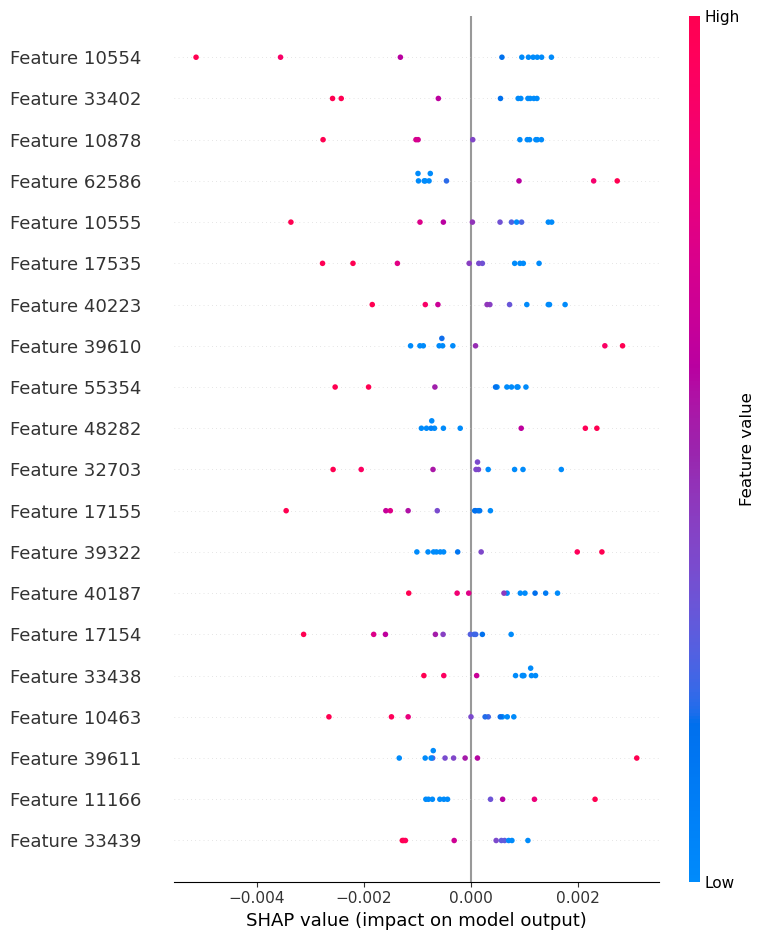

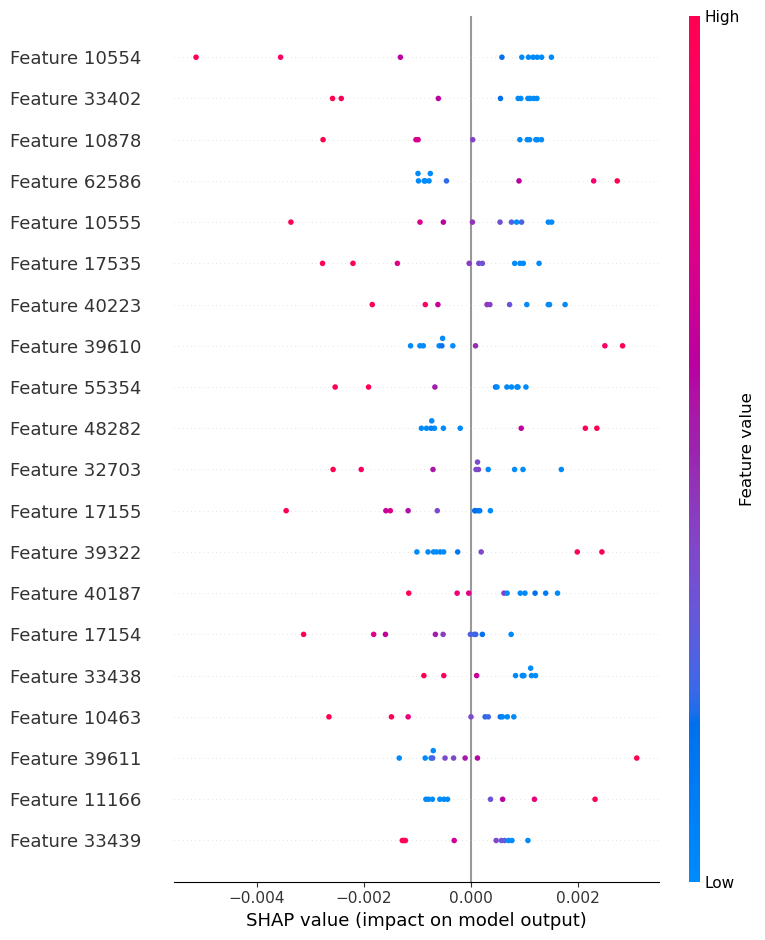

In [91]:
import shap
import numpy as np

# Selecciona aleatoriamente 100 muestras en lugar de 5000
background_samples = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# Usar DeepExplainer (corrected from your comment about GradientExplainer)
explainer = shap.DeepExplainer(model_shap, background_samples)

# Calcular valores SHAP
shap_values = explainer.shap_values(x_test[:10])

# Selecciona los valores SHAP para la clase 0
shap_values_class_0 = shap_values[0]  # Shape: (10, height, width, channels) or similar

# Flatten the SHAP values and x_test to 2D
shap_values_flat = shap_values_class_0.reshape(10, -1)  # Shape: (10, height*width*channels)
x_test_flat = x_test[:10].reshape(10, -1)  # Shape: (10, height*width*channels)

# Visualiza los valores SHAP para las primeras 10 muestras
shap.summary_plot(shap_values_flat, x_test_flat)

# Visualizar resultados con más características mostradas
shap.summary_plot(shap_values_flat, x_test_flat, max_display=20)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


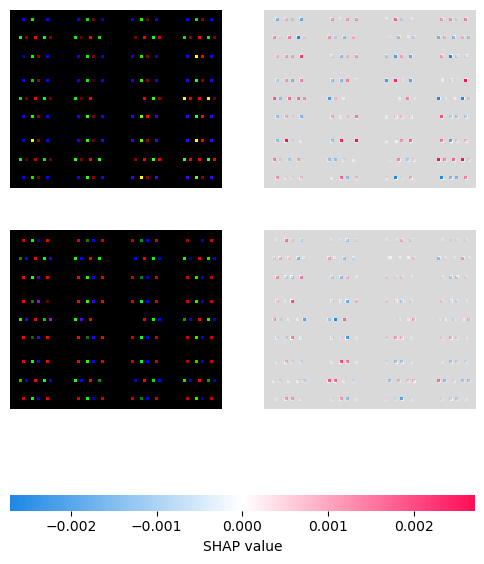

In [94]:
import shap
import numpy as np

# Selecciona aleatoriamente 100 muestras en lugar de 5000
background_samples = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# Usar DeepExplainer
explainer = shap.DeepExplainer(model_shap, background_samples)

# Calcular valores SHAP
shap_values = explainer.shap_values(x_test[:2])

# Selecciona los valores SHAP para la clase 0
shap_values_class_0 = shap_values[1]  # Shape: (10, height, width, channels) or similar

# Visualiza los valores SHAP como imágenes
shap.image_plot(shap_values_class_0, x_test[:2])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


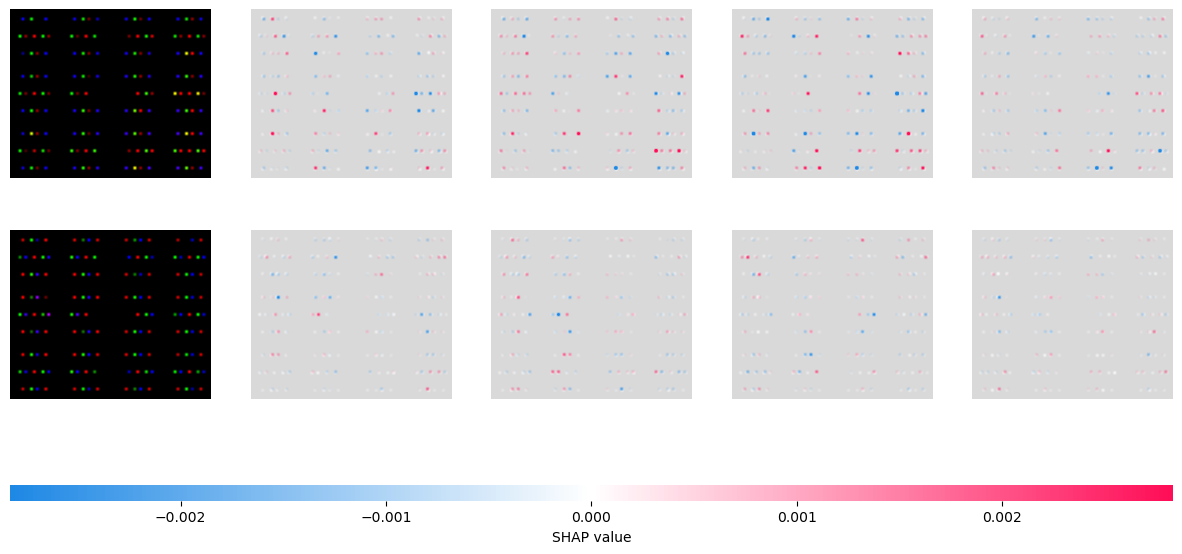

In [96]:
import shap
import numpy as np

# Selecciona aleatoriamente 100 muestras en lugar de 5000
background_samples = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# Usar DeepExplainer para el modelo de regresión
explainer = shap.DeepExplainer(model_shap, background_samples)

# Calcular valores SHAP (en regresión, no hay lista, solo un array)
shap_values = explainer.shap_values(x_test[:2])

# En regresión, shap_values no es una lista, así que no usamos [0]
# shap_values ya contiene los valores SHAP para las 10 muestras
# Shape esperado: (10, height, width, channels)

# Visualiza los valores SHAP como imágenes
shap.image_plot(shap_values, x_test[:2])

In [88]:
print("SHAP values shape:", np.shape(shap_values))
print("x_test shape:", np.shape(x_test[:10]))


SHAP values shape: (4, 10, 59, 70, 16)
x_test shape: (10, 59, 70, 16)


### Training

In [70]:
y_pred_pe, history_pe= train_and_predict(model_pe, x_train_pe, y_train, x_test_pe, y_test, epochs=100, batch_size=16)

Epoch 1/100
961/961 [==============================] - 10s 10ms/step - loss: 0.2140 - mse: 0.2140 - val_loss: 0.0625 - val_mse: 0.0625 - lr: 0.0010
Epoch 2/100
961/961 [==============================] - 7s 8ms/step - loss: 0.0692 - mse: 0.0692 - val_loss: 0.0491 - val_mse: 0.0491 - lr: 0.0010
Epoch 3/100
961/961 [==============================] - 7s 8ms/step - loss: 0.0585 - mse: 0.0585 - val_loss: 0.0447 - val_mse: 0.0447 - lr: 0.0010
Epoch 4/100
961/961 [==============================] - 7s 7ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0892 - val_mse: 0.0892 - lr: 0.0010
Epoch 5/100
961/961 [==============================] - 7s 7ms/step - loss: 0.0505 - mse: 0.0505 - val_loss: 0.0549 - val_mse: 0.0549 - lr: 0.0010
Epoch 6/100
961/961 [==============================] - 7s 7ms/step - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0756 - val_mse: 0.0756 - lr: 0.0010
Epoch 7/100
960/961 [============================>.] - ETA: 0s - loss: 0.0459 - mse: 0.0459
Epoch 00007: ReduceLROnPlateau

In [56]:
y_pred_3, history_3= train_and_predict(model_3, x_train, y_train, x_test, y_test, epochs=100, batch_size=16)

2025-03-18 01:15:54.287590: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4063920000 exceeds 10% of free system memory.
2025-03-18 01:15:57.349311: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4063920000 exceeds 10% of free system memory.


Epoch 1/100
961/961 [==============================] - 12s 12ms/step - loss: 0.3077 - mse: 0.3077 - val_loss: 0.0796 - val_mse: 0.0796 - lr: 0.0010
Epoch 2/100
961/961 [==============================] - 8s 8ms/step - loss: 0.0802 - mse: 0.0802 - val_loss: 0.0544 - val_mse: 0.0544 - lr: 0.0010
Epoch 3/100
961/961 [==============================] - 8s 8ms/step - loss: 0.0647 - mse: 0.0647 - val_loss: 0.0523 - val_mse: 0.0523 - lr: 0.0010
Epoch 4/100
961/961 [==============================] - 8s 8ms/step - loss: 0.0586 - mse: 0.0586 - val_loss: 0.0473 - val_mse: 0.0473 - lr: 0.0010
Epoch 5/100
961/961 [==============================] - 8s 8ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0415 - val_mse: 0.0415 - lr: 0.0010
Epoch 6/100
961/961 [==============================] - 8s 8ms/step - loss: 0.0531 - mse: 0.0531 - val_loss: 0.0417 - val_mse: 0.0417 - lr: 0.0010
Epoch 7/100
961/961 [==============================] - 8s 8ms/step - loss: 0.0503 - mse: 0.0503 - val_loss: 0.0401 - val_m

### Análisis de los pesos de cada rama

In [ ]:
import numpy as np
from tensorflow.keras import layers

# Supongamos que ya tienes tu modelo entrenado y lo llamas 'model_def'
# Extraemos la primera capa convolucional
first_conv_layer = [layer for layer in current_model3.layers if isinstance(layer, layers.Conv2D)][0]

# Extraemos los pesos de la primera capa.
# Los pesos tienen forma: (kernel_height, kernel_width, canales, filtros)
weights = first_conv_layer.get_weights()[0]

# Supongamos que tienes 16 canales y la distribución es la siguiente:
# Canales: [0,1] -> fotoelectrones, [2,3] -> tiempos, [4,5] -> fotoelectrones, [6,7] -> tiempos, ...
num_channels = weights.shape[2]  # Debería ser 16 en este caso

photo_indices = []
time_indices = []
num_pairs = num_channels // 2  # número de pares de canales

for pair in range(num_pairs):
    if pair % 2 == 0:
        # Para pares pares, los dos canales pertenecen a fotoelectrones.
        photo_indices.extend([2 * pair, 2 * pair + 1])
    else:
        # Para pares impares, los dos canales pertenecen a tiempos.
        time_indices.extend([2 * pair, 2 * pair + 1])

print("Índices de fotoelectrones:", photo_indices)
print("Índices de tiempos:", time_indices)

# Extraer los pesos correspondientes a cada grupo
photo_weights = weights[:, :, photo_indices, :]
time_weights = weights[:, :, time_indices, :]

photo_importance = np.linalg.norm(photo_weights)
time_importance = np.linalg.norm(time_weights)


# Calcular el ratio
ratio = photo_importance / (time_importance + 1e-8)  # Se agrega epsilon para evitar división por cero

print("Importancia total - Fotoelectrones:", photo_importance)
print("Importancia total - Tiempos:", time_importance)
print("Ratio (Fotoelectrones/Tiempos):", ratio)

In [15]:
def pertenece_a_rama(layer, nombre_input):
    """
    Retorna True si, siguiendo recursivamente los nodos de entrada,
    se llega a una capa InputLayer cuyo nombre contiene 'nombre_input'.
    """
    # Si la capa es un InputLayer, verificamos su nombre.
    if isinstance(layer, layers.InputLayer):
        return nombre_input in layer.name
    
    # Recorrer los nodos de entrada de la capa.
    for node in layer._inbound_nodes:
        # Aseguramos que input_tensors es una lista:
        input_tensors = node.input_tensors
        if not isinstance(input_tensors, (list, tuple)):
            input_tensors = [input_tensors]
        for tensor in input_tensors:
            # tensor._keras_history es una tupla: (layer, node_index, tensor_index)
            capa_origen = tensor._keras_history.layer
            if pertenece_a_rama(capa_origen, nombre_input):
                return True
    return False

In [16]:
# Encontrar el índice de la capa de concatenación
concat_index = [i for i, layer in enumerate(current_model5.layers) if isinstance(layer, layers.Concatenate)][0]

# Capas de la rama PE: antes de la concatenación y conectadas (directa o indirectamente) al input_1
pe_layers = [layer for layer in current_model5.layers[:concat_index]
             if 'conv2d' in layer.name and pertenece_a_rama(layer, 'input_1')]

# Capas de la rama Time: antes de la concatenación y conectadas (directa o indirectamente) al input_2
time_layers = [layer for layer in current_model5.layers[:concat_index]
               if 'conv2d' in layer.name and pertenece_a_rama(layer, 'input_2')]

print("Capas de la rama PE:")
for layer in pe_layers:
    print(layer.name)

print("\nCapas de la rama Time:")
for layer in time_layers:
    print(layer.name)


Capas de la rama PE:
conv2d
conv2d_1
conv2d_2
conv2d_3

Capas de la rama Time:
conv2d_4
conv2d_5
conv2d_6
conv2d_7


In [17]:
pe_weights = [layer.get_weights()[0] for layer in pe_layers]  
time_weights = [layer.get_weights()[0] for layer in time_layers]

In [18]:
# Calcular la norma de los pesos de cada rama
pe_norms = [np.linalg.norm(w) for w in pe_weights]
time_norms = [np.linalg.norm(w) for w in time_weights]

# Sumar todas las normas para cada rama
total_pe_importance = sum(pe_norms)
total_time_importance = sum(time_norms)

print(f"Importancia total de la rama PE: {total_pe_importance}")
print(f"Importancia total de la rama Time: {total_time_importance}")

print(f"Cociente de los pesos total_pe_importance/ total_time_importance: {total_pe_importance/ total_time_importance}")

Importancia total de la rama PE: 88.90062522888184
Importancia total de la rama Time: 86.62672901153564
Cociente de los pesos total_pe_importance/ total_time_importance: 1.0262493602528082


In [25]:
# Obtener los pesos de la última capa de cada rama
last_pe_weights = pe_layers[0].get_weights()[0]  # Última capa de la rama PE
last_time_weights = time_layers[0].get_weights()[0]  # Última capa de la rama Time

# Calcular la norma de los pesos de la última capa de cada rama
last_pe_norm = np.linalg.norm(last_pe_weights)
last_time_norm = np.linalg.norm(last_time_weights)

print(f"Norma de los pesos de la última capa de la rama PE: {last_pe_norm}")
print(f"Norma de los pesos de la última capa de la rama Time: {last_time_norm}")
print(f"Cociente de los pesos last_pe_norm/ last_time_norm: {last_pe_norm/ last_time_norm}")

Norma de los pesos de la última capa de la rama PE: 9.29953384399414
Norma de los pesos de la última capa de la rama Time: 7.5808916091918945
Cociente de los pesos last_pe_norm/ last_time_norm: 1.226707100868225


In [15]:
#current_model.save('saved_archives/ophit_cnn_model_v2101_c_1.h5')

### Plots rendimiento modelo

In [71]:
# Initialize a copy of the scaled combined data
y_pred_inverse= np.copy(y_pred_pe)
y_test_inverse= np.copy(y_test)

# Inverse scaling for columns scaled to [0, 1]
y_pred_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_pred_pe[:, columns_0_to_1])
y_test_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_test[:, columns_0_to_1])

# Inverse scaling for columns scaled to [-1, 1]
y_pred_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_pred_pe[:, columns_minus1_to_1])
y_test_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_test[:, columns_minus1_to_1])

In [44]:
print(y_pred_inverse[:,0])
print(y_test_inverse[:,0])

[1098.2153   887.41644  166.36133 ...  850.733    333.44434  233.12683]
[1463.30189659 1082.21084653  303.2553923  ...  892.05321466  514.28380099
  268.1399194 ]


In [43]:
y_pred_inverse[:,0] = np.max(y_pred_inverse[:,0])- y_pred_inverse[:,0] + np.min(y_pred_inverse[:,0])
y_test_inverse[:,0] = np.max(y_test_inverse[:,0]) - y_test_inverse[:,0] + np.min(y_test_inverse[:,0])

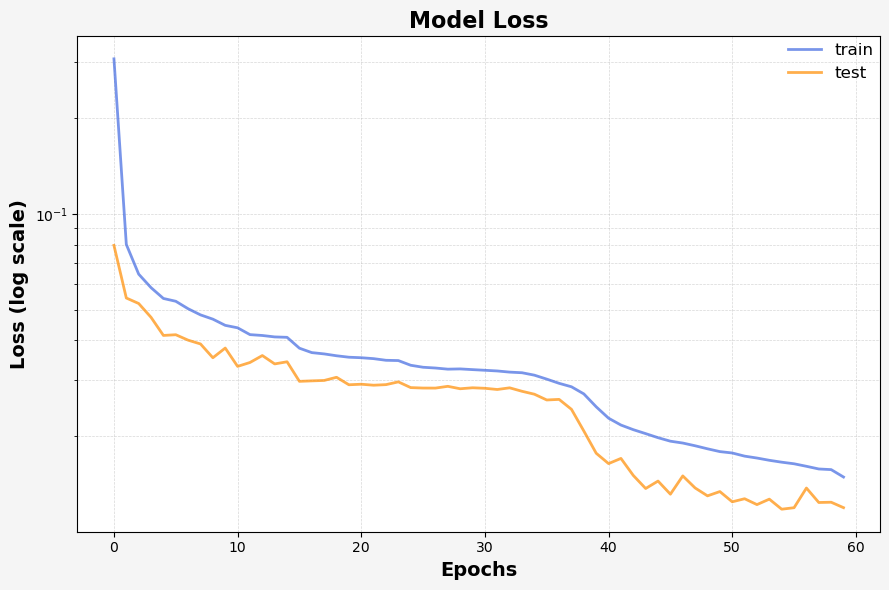

In [58]:
import matplotlib.pyplot as plt

# Access each model's history
model_history = history_3.history


# Plotting the validation loss for all models
plt.figure(figsize=(9, 6))

# Plot each model's validation loss with smoother lines, subtle markers, and clearer styling
# Training curves (using shades of blue and green)
plt.plot(model_history['loss'], label='train', color='royalblue', linestyle='-', markersize=6, alpha=0.7, linewidth=2)


# Testing curves (using shades of orange and red)
plt.plot(model_history['val_loss'], label='test', color='darkorange', linestyle='-', markersize=6, alpha=0.7, linewidth=2)


# Enhance plot appearance
plt.yscale('log')  # Use logarithmic scale on y-axis
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss (log scale)', fontsize=14, fontweight='bold')
plt.title('Model Loss', fontsize=16, fontweight='bold')

# Refined grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Add legend with better positioning and larger font
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

# Add background color for plot to make it stand out
plt.gcf().set_facecolor('whitesmoke')

# Show plot with a tight layout to avoid clipping
plt.tight_layout()
plt.show()


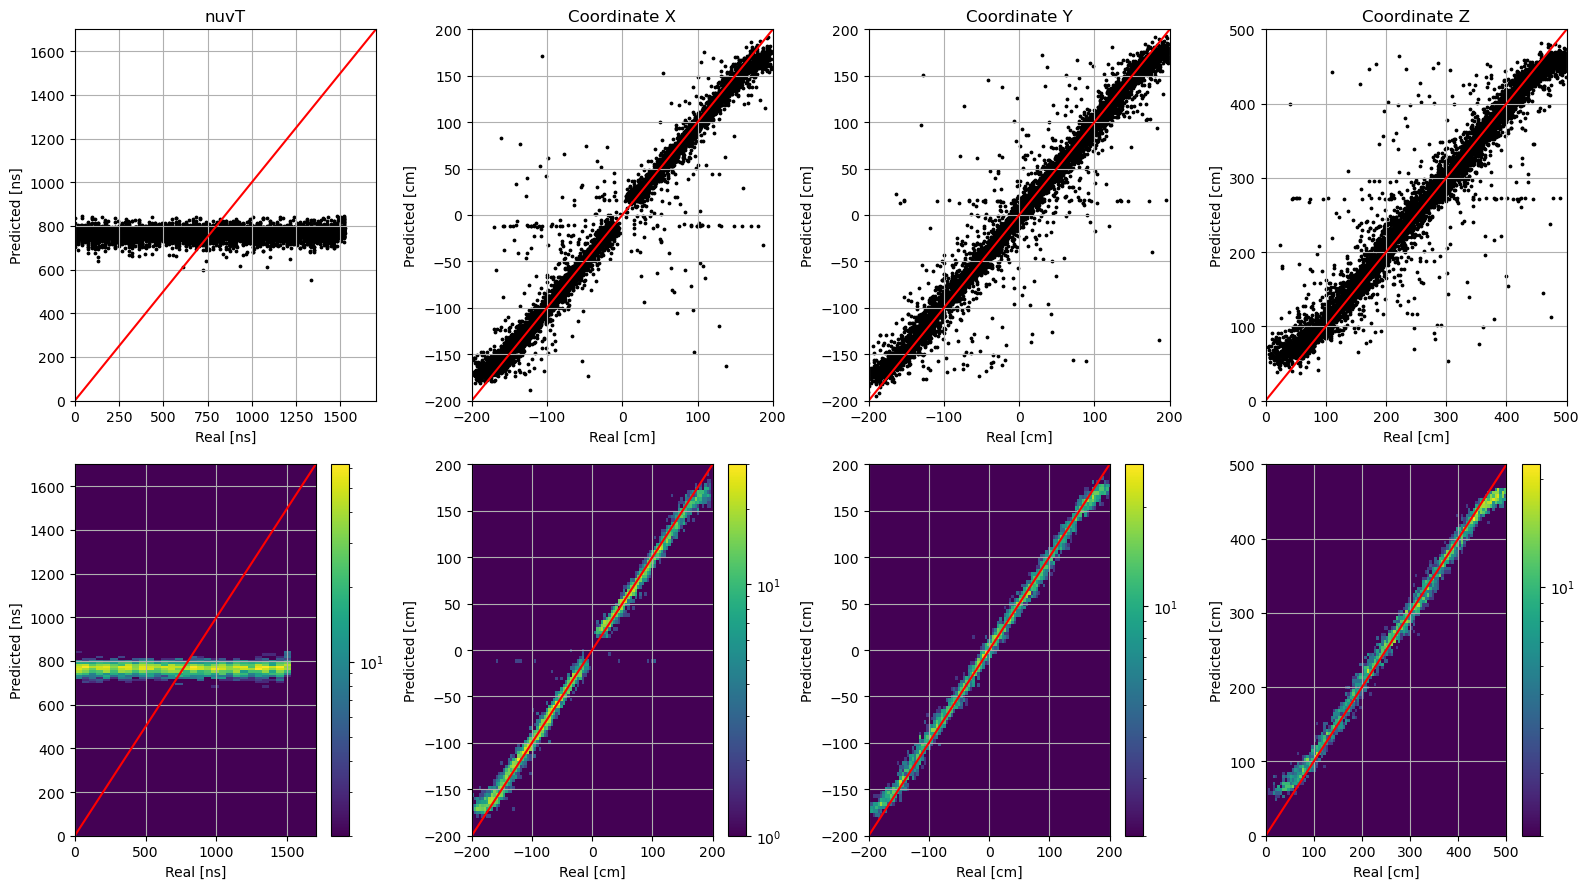

In [72]:
import matplotlib.colors as mcolors
fig, axs = plt.subplots(2,4,figsize=(16,9))

axs[0,0].scatter(y_test_inverse[:,0], y_pred_inverse[:,0], color="black",s=3)
axs[0,0].grid()

axs[0,0].plot([0,1700],[0,1700],color="r")
axs[0,0].title.set_text('nuvT')
axs[0,0].set_xlim([0,1700])
axs[0,0].set_ylim([0,1700])
axs[0,0].set_ylabel('Predicted [ns]')
axs[0,0].set_xlabel('Real [ns]')

im0 = axs[1,0].hist2d(y_test_inverse[:,0], y_pred_inverse[:,0].flatten(), bins=(30, 30), cmap='viridis', cmin=2, norm=mcolors.LogNorm())
fig.colorbar(im0[3], ax=axs[1,0])
axs[1,0].grid()

axs[1,0].plot([0,1700],[0,1700],'r')
axs[1,0].set_xlim([0,1700])
axs[1,0].set_ylim([0,1700])
axs[1,0].set_ylabel('Predicted [ns]')
axs[1,0].set_xlabel('Real [ns]')
axs[1,0].set_facecolor('#440154')


axs[0,1].scatter(y_test_inverse[:,1], y_pred_inverse[:,1], color="black",s=3)
axs[0,1].grid()

axs[0,1].plot([-200,200],[-200,200],color="r")
axs[0,1].title.set_text('Coordinate X')
axs[0,1].set_xlim([-200,200])
axs[0,1].set_ylim([-200,200])
axs[0,1].set_ylabel('Predicted [cm]')
axs[0,1].set_xlabel('Real [cm]')


im1 = axs[1,1].hist2d(y_test_inverse[:,1], y_pred_inverse[:,1].flatten(), bins=(100, 100), cmap='viridis', cmin=0,cmax=30, norm=mcolors.LogNorm())
fig.colorbar(im1[3], ax=axs[1,1])
axs[1,1].grid()

axs[1,1].plot([-200,200],[-200,200],'r')
axs[1,1].set_xlim([-200,200])
axs[1,1].set_ylim([-200,200])
axs[1,1].set_ylabel('Predicted [cm]')
axs[1,1].set_xlabel('Real [cm]')
axs[1,1].set_facecolor('#440154')


axs[0,2].scatter(y_test_inverse[:,2], y_pred_inverse[:,2], color="black",s=3)
axs[0,2].grid()

axs[0,2].plot([-200,200],[-200,200],color="r")
axs[0,2].title.set_text('Coordinate Y')
axs[0,2].set_xlim([-200,200])
axs[0,2].set_ylim([-200,200])
axs[0,2].set_ylabel('Predicted [cm]')
axs[0,2].set_xlabel('Real [cm]')


im2 = axs[1,2].hist2d(y_test_inverse[:,2], y_pred_inverse[:,2].flatten(), bins=(100, 100), cmap='viridis',cmin=2, cmax=30, norm=mcolors.LogNorm())
fig.colorbar(im2[3], ax=axs[1,2])
axs[1,2].grid()

axs[1,2].plot([-200,200],[-200,200],'r')
axs[1,2].set_xlim([-200,200])
axs[1,2].set_ylim([-200,200])
axs[1,2].set_ylabel('Predicted [cm]')
axs[1,2].set_xlabel('Real [cm]')
axs[1,2].set_facecolor('#440154')


axs[0,3].scatter(y_test_inverse[:,3], y_pred_inverse[:,3], color="black",s=3)
axs[0,3].grid()

axs[0,3].plot([0,500],[0,500],color="r")
axs[0,3].title.set_text('Coordinate Z')
axs[0,3].set_xlim([0,500])
axs[0,3].set_ylim([0,500])
axs[0,3].set_ylabel('Predicted [cm]')
axs[0,3].set_xlabel('Real [cm]')


im3 = axs[1,3].hist2d(y_test_inverse[:,3], y_pred_inverse[:,3].flatten(), bins=(100, 100), cmap='viridis',cmin=2, cmax=30, norm=mcolors.LogNorm())
fig.colorbar(im3[3], ax=axs[1,3])
axs[1,3].grid()

axs[1,3].set_xlim([0,500])
axs[1,3].set_ylim([0,500])
axs[1,3].plot([0,500],[0,500], 'r')
axs[1,3].set_ylabel('Predicted [cm]')
axs[1,3].set_xlabel('Real [cm]')
axs[1,3].set_facecolor('#440154')

fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

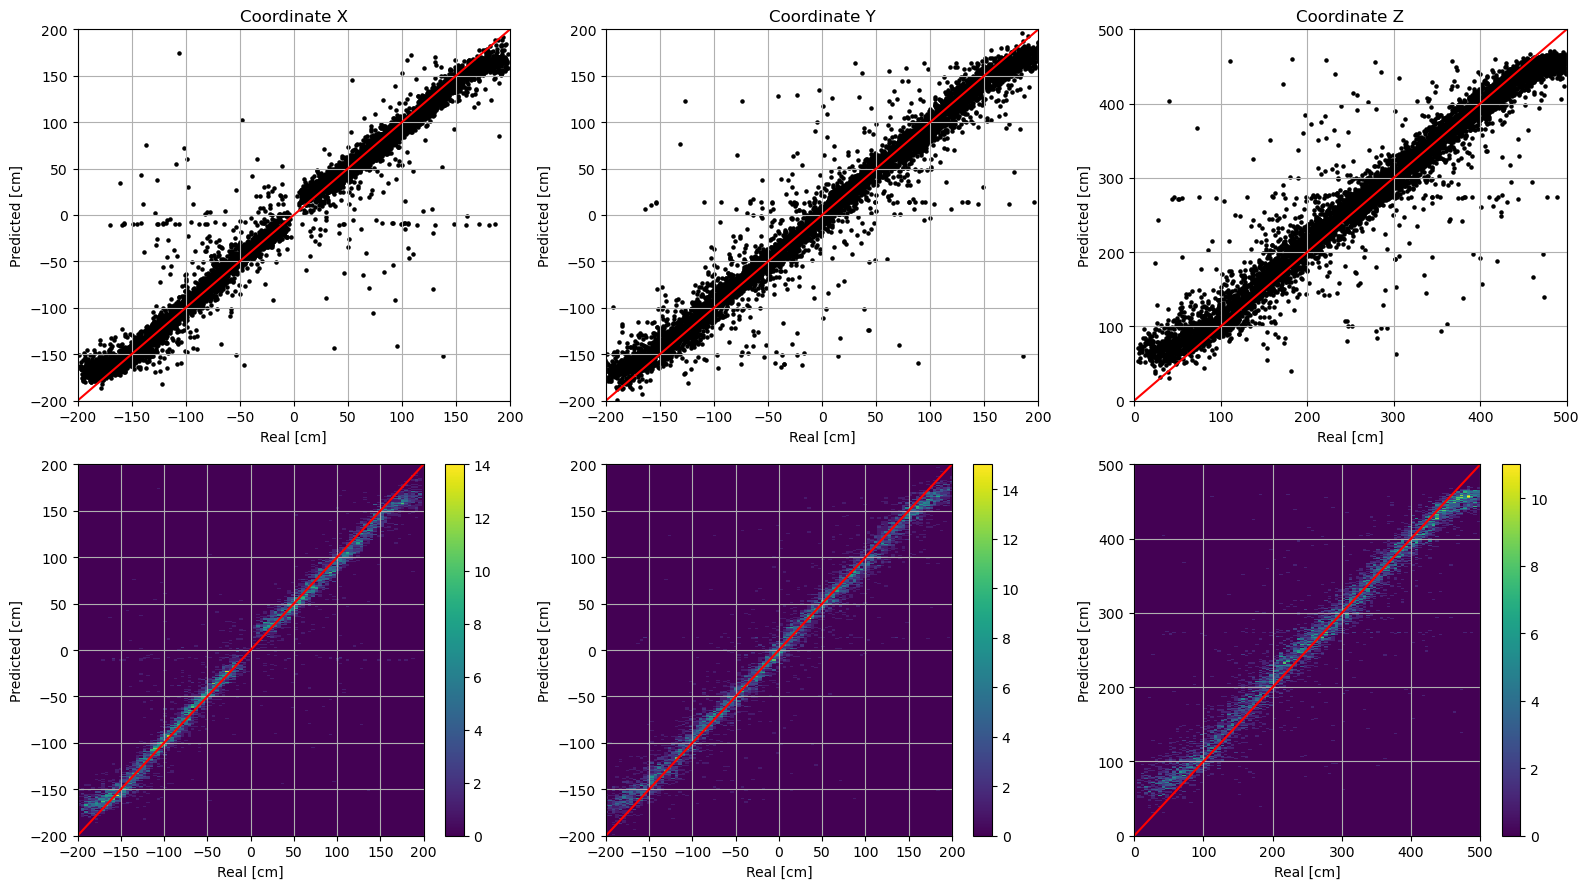

In [63]:
fig, axs = plt.subplots(2,3,figsize=(16,9))



axs[0,0].scatter(y_test_inverse[:,0], y_pred_inverse[:,0], color="black",s=5)
axs[0,0].grid()

axs[0,0].plot([-200,200],[-200,200],color="r")
axs[0,0].title.set_text('Coordinate X')
axs[0,0].set_xlim([-200,200])
axs[0,0].set_ylim([-200,200])
axs[0,0].set_ylabel('Predicted [cm]')
axs[0,0].set_xlabel('Real [cm]')


im1 = axs[1,0].hist2d(y_test_inverse[:,0], y_pred_inverse[:,0].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im1[3], ax=axs[1,0])
axs[1,0].grid()

axs[1,0].plot([-200,200],[-200,200],'r')
axs[1,0].set_xlim([-200,200])
axs[1,0].set_ylim([-200,200])
axs[1,0].set_ylabel('Predicted [cm]')
axs[1,0].set_xlabel('Real [cm]')
axs[1,0].set_facecolor('#440154')


axs[0,1].scatter(y_test_inverse[:,1], y_pred_inverse[:,1], color="black",s=5)
axs[0,1].grid()

axs[0,1].plot([-200,200],[-200,200],color="r")
axs[0,1].title.set_text('Coordinate Y')
axs[0,1].set_xlim([-200,200])
axs[0,1].set_ylim([-200,200])
axs[0,1].set_ylabel('Predicted [cm]')
axs[0,1].set_xlabel('Real [cm]')


im2 = axs[1,1].hist2d(y_test_inverse[:,1], y_pred_inverse[:,1].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im2[3], ax=axs[1,1])
axs[1,1].grid()

axs[1,1].plot([-200,200],[-200,200],'r')
axs[1,1].set_xlim([-200,200])
axs[1,1].set_ylim([-200,200])
axs[1,1].set_ylabel('Predicted [cm]')
axs[1,1].set_xlabel('Real [cm]')
axs[1,1].set_facecolor('#440154')


axs[0,2].scatter(y_test_inverse[:,2], y_pred_inverse[:,2], color="black",s=5)
axs[0,2].grid()

axs[0,2].plot([0,500],[0,500],color="r")
axs[0,2].title.set_text('Coordinate Z')
axs[0,2].set_xlim([0,500])
axs[0,2].set_ylim([0,500])
axs[0,2].set_ylabel('Predicted [cm]')
axs[0,2].set_xlabel('Real [cm]')


im3 = axs[1,2].hist2d(y_test_inverse[:,2], y_pred_inverse[:,2].flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im3[3], ax=axs[1,2])
axs[1,2].grid()

axs[1,2].set_xlim([0,500])
axs[1,2].set_ylim([0,500])
axs[1,2].plot([0,500],[0,500], 'r')
axs[1,2].set_ylabel('Predicted [cm]')
axs[1,2].set_xlabel('Real [cm]')
axs[1,2].set_facecolor('#440154')

fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

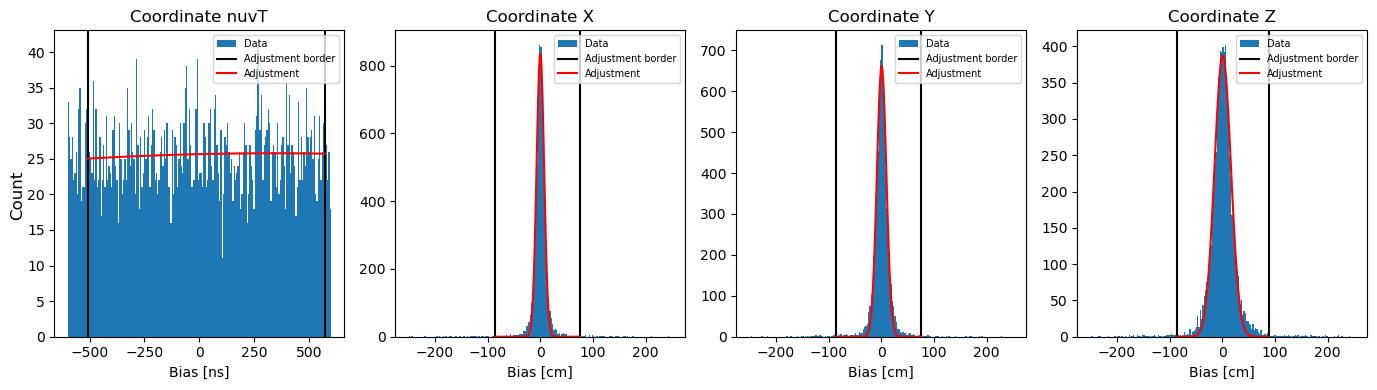

Bias Adjustment variables
------------------
Mean nuvT = 344.07
Sigma nuvT = 3520.26
------------------
Mean X = 0.17
Sigma X = 7.08
------------------
Mean Y = 0.79
Sigma Y = 8.96
------------------
Mean Z = 1.01
Sigma Z = 15.56
------------------


In [73]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value
diffnuvT = y_pred_inverse[:, 0].flatten() - y_test_inverse[:, 0]
diffX = y_pred_inverse[:, 1].flatten() - y_test_inverse[:, 1]
diffY = y_pred_inverse[:, 2].flatten() - y_test_inverse[:, 2]
diffZ = y_pred_inverse[:, 3].flatten() - y_test_inverse[:, 3]

# Create subplots for each coordinate
fig, axs = plt.subplots(1, 4, figsize=(14, 4))

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, axs, index, coord_name, ini, fin, hist_range):
    counts, bins, patches = axs[index].hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    axs[index].axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    axs[index].axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0, bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf]))
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    axs[index].plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    axs[index].set_xlabel('Bias [cm]' if coord_name != 'nuvT' else 'Bias [ns]')  # Set different xlabel for nuvT
    axs[index].set_title(f'Coordinate {coord_name}')
    axs[index].legend(prop={"size": 7})

    return popt

# Call the function with updated range for nuvT
popt_nuvT = fit_and_plot_hist(diffnuvT, axs, 0, 'nuvT', 15, 195, hist_range=[-600, 600])
popt_X = fit_and_plot_hist(diffX, axs, 1, 'X', 65, 130, hist_range=[-250, 250])
popt_Y = fit_and_plot_hist(diffY, axs, 2, 'Y', 65, 130, hist_range=[-250, 250])
popt_Z = fit_and_plot_hist(diffZ, axs, 3, 'Z', 65, 135, hist_range=[-250, 250])


# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean nuvT = {popt_nuvT[1]:.2f}')
print(f'Sigma nuvT = {popt_nuvT[2]:.2f}')
print('------------------')
print(f'Mean X = {popt_X[1]:.2f}')
print(f'Sigma X = {popt_X[2]:.2f}')
print('------------------')
print(f'Mean Y = {popt_Y[1]:.2f}')
print(f'Sigma Y = {popt_Y[2]:.2f}')
print('------------------')
print(f'Mean Z = {popt_Z[1]:.2f}')
print(f'Sigma Z = {popt_Z[2]:.2f}')
print('------------------')


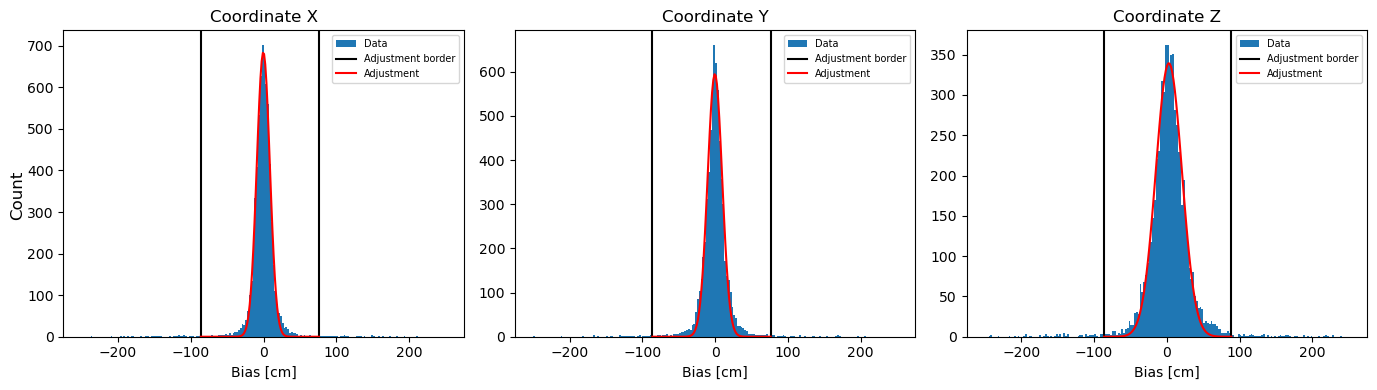

Bias Adjustment variables
------------------
Mean X = -0.26
Sigma X = 8.95
------------------
Mean Y = -0.40
Sigma Y = 9.99
------------------
Mean Z = 2.78
Sigma Z = 17.94
------------------


In [64]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value

diffX = y_pred_inverse[:, 0].flatten() - y_test_inverse[:, 0]
diffY = y_pred_inverse[:, 1].flatten() - y_test_inverse[:, 1]
diffZ = y_pred_inverse[:, 2].flatten() - y_test_inverse[:, 2]

# Create subplots for each coordinate
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, axs, index, coord_name, ini, fin, hist_range):
    counts, bins, patches = axs[index].hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    axs[index].axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    axs[index].axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0)
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    axs[index].plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    axs[index].set_xlabel('Bias [cm]' if coord_name != 'nuvT' else 'Bias [ns]')  # Set different xlabel for nuvT
    axs[index].set_title(f'Coordinate {coord_name}')
    axs[index].legend(prop={"size": 7})

    return popt

# Call the function with updated range for nuvT

popt_X = fit_and_plot_hist(diffX, axs, 0, 'X', 65, 130, hist_range=[-250, 250])
popt_Y = fit_and_plot_hist(diffY, axs, 1, 'Y', 65, 130, hist_range=[-250, 250])
popt_Z = fit_and_plot_hist(diffZ, axs, 2, 'Z', 65, 135, hist_range=[-250, 250])


# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean X = {popt_X[1]:.2f}')
print(f'Sigma X = {popt_X[2]:.2f}')
print('------------------')
print(f'Mean Y = {popt_Y[1]:.2f}')
print(f'Sigma Y = {popt_Y[2]:.2f}')
print('------------------')
print(f'Mean Z = {popt_Z[1]:.2f}')
print(f'Sigma Z = {popt_Z[2]:.2f}')
print('------------------')


In [23]:
r2_x = r2_score(y_test_inverse[:, 0], y_pred_inverse[:, 0])     # Coordinate X
r2_y = r2_score(y_test_inverse[:, 1], y_pred_inverse[:, 1])     # Coordinate Y
r2_z = r2_score(y_test_inverse[:, 2], y_pred_inverse[:, 2])     # Coordinate Z

print(f"R2 (X): {r2_x:.4f}")
print(f"R2 (Y): {r2_y:.4f}")
print(f"R2 (Z): {r2_z:.4f}")

R2 (X): 0.9271
R2 (Y): 0.9001
R2 (Z): 0.9030


In [20]:
print('Gauss X')
print(np.std(diffX))
print(np.mean(diffX))

print('Gauss Y')
print(np.std(diffY))
print(np.mean(diffY))

print('Gauss Z')
print(np.std(diffZ))
print(np.mean(diffZ))

Gauss X
27.393241757766475
-0.6142951600290327
Gauss Y
27.236566239665013
-0.5034220949984536
Gauss Z
39.414459044481234
1.1878635292522397


### Visualize intermediate layers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def visualize_intermediate_layers(model, x_train, sample_index=0):
    """
    Visualizes intermediate layer outputs for a specific sample from the training data.
    
    Parameters:
    - model: The trained Keras model.
    - x_train: The training data.
    - sample_index: Index of the sample from x_train to visualize.
    """
    # Get the outputs of all intermediate layers
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = Model(inputs=model.input, outputs=successive_outputs)
    
    # Select a sample image from x_train
    sample_image = x_train[sample_index:sample_index + 1]  # Shape should be (1, height, width, channels)
    
    # Pass the image through the model to get intermediate representations
    successive_feature_maps = visualization_model.predict(sample_image)
    
    # Get layer names for labeling
    layer_names = [layer.name for layer in model.layers[1:]]
    
    # Plot each layer's feature map
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
        if len(feature_map.shape) == 4:  # Only consider convolutional layers (ignore dense layers)
            n_features = feature_map.shape[-1]  # Number of filters
            size = feature_map.shape[1]  # Spatial dimensions
            
            # Create a grid for visualizing each filter's feature map
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                
                # Normalize the feature map values for better visualization
                x -= x.mean()
                x /= (x.std() + 1e-5)
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                
                # Resize or pad `x` if it doesn't match the expected dimensions
                if x.shape[1] < size:
                    x = np.pad(x, ((0, 0), (0, size - x.shape[1])), mode='constant')
                elif x.shape[1] > size:
                    x = x[:, :size]
                
                # Put each filter's activation in the display grid
                display_grid[:, i * size : (i + 1) * size] = x
            
            # Display the grid
            scale = 20. / n_features
            plt.figure(figsize=(scale * n_features, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.show()

# Use the function to visualize intermediate representations of your model
# Assuming x_train is your training data and create_cnn_model has been defined
#model, _ = create_cnn_model(x_train, conv_dim=(3, 3), maxpool_dim=(2, 2))
#visualize_intermediate_layers(model, x_train)


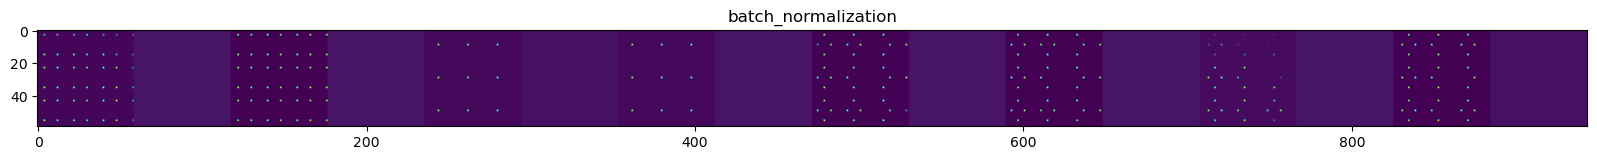

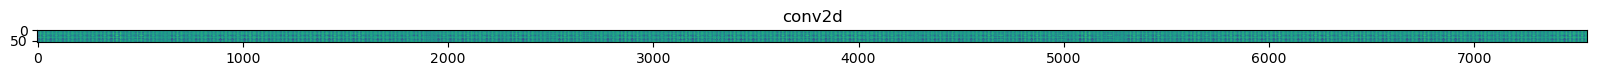

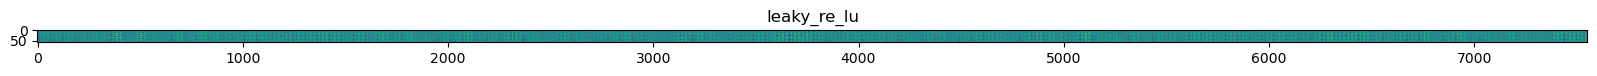

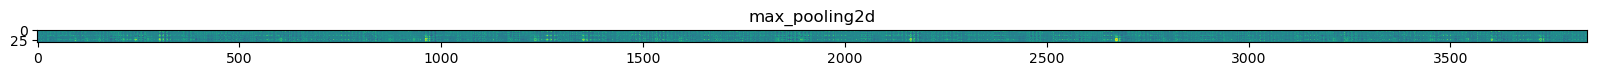

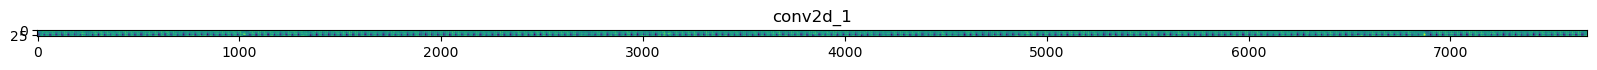

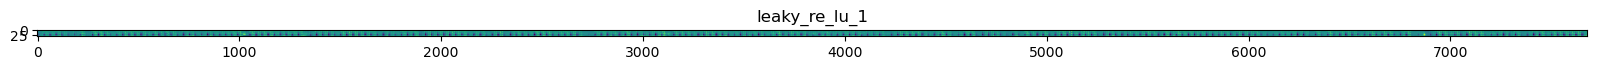

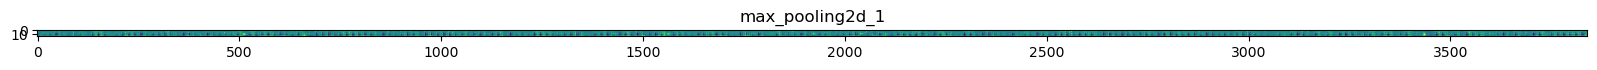

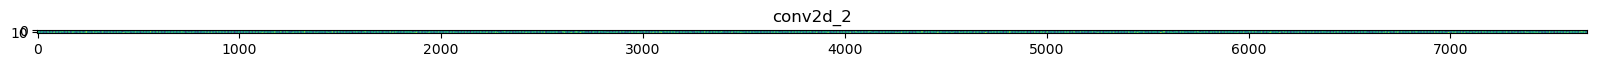

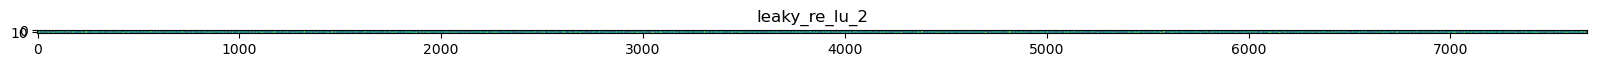

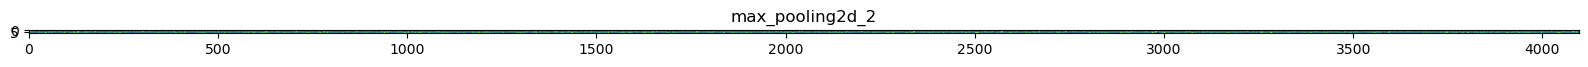

In [ ]:
visualize_intermediate_layers(model_4compreal, x_train)

### Visualize areas of interest

In [3]:
try:
    current_model = tf.keras.models.load_model('saved_archives/ophit_cnn_model_v2101_c_1.h5')
    print("Modelo cargado exitosamente.")
except Exception as e:
    print("Error al cargar el modelo:", e)

Modelo cargado exitosamente.


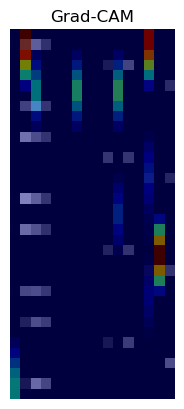

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import cv2

def generate_gradcam(model, image, layer_name='conv2d', class_idx=None):
    # Crea un modelo que extrae las activaciones de la capa convolucional seleccionada
    grad_model = Model(inputs=model.input,
                       outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        # Asegúrate de que los valores de la imagen sean flotantes y habilita el cálculo de gradientes
        image_input = tf.convert_to_tensor(image, dtype=tf.float32)
        tape.watch(image_input)
        
        # Calcula las activaciones de la capa y la salida de la red
        conv_outputs, predictions = grad_model(image_input)
        
        if class_idx is None:
            # Si no se especifica un índice de clase, se usa el índice de la clase con mayor probabilidad
            class_idx = np.argmax(predictions.numpy())
        
        # Calcula los gradientes de la clase seleccionada con respecto a las activaciones de la capa
        grads = tape.gradient(predictions[:, class_idx], conv_outputs)
        
    # Promedia los gradientes a través de la dimensión de los canales
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplica las activaciones por los gradientes ponderados
    cam = np.dot(conv_outputs[0], pooled_grads.numpy())

    # Escala el mapa para que tenga valores entre 0 y 1
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)

    return cam

def display_gradcam(image, cam, title="Grad-CAM"):
    # Redimensiona el mapa de activación para que coincida con las dimensiones de la imagen
    cam_resized = cv2.resize(cam, (image.shape[1], image.shape[0]))
    
    # Muestra la imagen original con el mapa de activación superpuesto
    plt.imshow(image, cmap='gray')
    plt.imshow(cam_resized, cmap='jet', alpha=0.5)  # Mapa de calor en la imagen
    plt.title(title)
    plt.axis('off')
    plt.show()


# Asegúrate de que `image` tiene shape (1, 9, 36, 16)
# Si tu imagen original tiene más dimensiones, primero debes ajustar su forma.
# Si tienes varias imágenes, asegúrate de seleccionar una sola para gradcam:

# Aquí suponemos que la imagen tiene la forma correcta (1, 9, 36, 16)
image_input = image[3] 
image_input2 = image_input[None]  # Si 'image' tiene forma (9, 36, 16), agregamos la dimensión del batch

# Supongamos que `current_model` es tu modelo entrenado
gradcam = generate_gradcam(current_model, image_input2)  # El input debe tener shape (1, 9, 36, 16)
display_gradcam(image_input[0], gradcam)  # Ahora se pasa la imagen original de tamaño (9, 36, 16)


In [23]:
import matplotlib.pyplot as plt

def plot_gradcam(cam, title="Grad-CAM Heatmap"):
    # Display the Grad-CAM heatmap
    plt.imshow(cam, cmap='jet')  # Use 'jet' colormap for the heatmap
    plt.colorbar()  # Add color bar to show the heatmap intensity
    plt.title(title)  # Title of the plot
    plt.axis('off')  # Turn off axis labels
    plt.show()

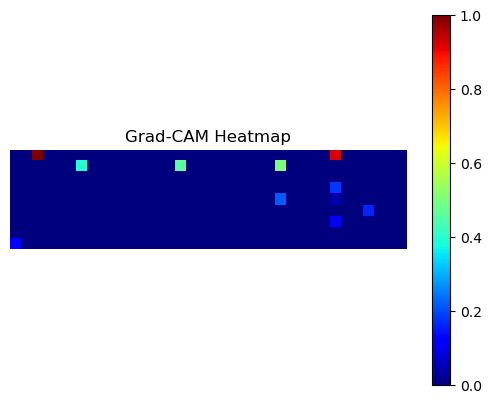

In [25]:
plot_gradcam(gradcam)

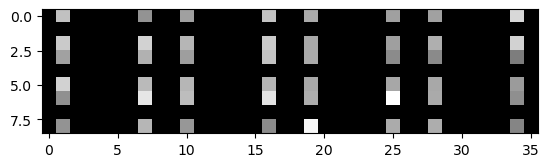

In [29]:
plt.imshow(image[3,:,:,2],cmap='gray')